**netCDF Setup Utility**

Use this notebook to set up empty netCDF files to be loaded onto each vessel. Currently, this setup utility only supports the use of two vessels.

In the cell below, please enter the required input files and runtime parameters or leave them as their default values.

In [43]:
# Survey area polygon file
survey_area_file = 'hh_parking.poly'

# Output netCDF files for each vessel
vesselA_output_file = 'vA_empty.nc'
vesselB_output_file = 'vB_empty.nc'

# Geodetic Parameters
input_geodetics = 'EPSG:4326'
project_geodetics = 'EPSG:32619'

# Vessel names, types, and equipment
vesselA_name = 'Kelp King'
vesselA_make = 'OSP Vessel'
vesselA_GNSS_type = 'single_code'
vesselA_sonar_type = 'singlebeam'

vesselB_name = 'Deux Banane'
vesselB_make = 'Seafloor Hydrone'
vesselB_GNSS_type = 'single_multi'
vesselB_sonar_type = 'singlebeam'

# Survey total propagated uncertainty parameters in meters
allowable_sigmaVertical = 0.15

vesselA_sigmaVertical = 0.1
vesselA_sigmaHorizontal = 0.2

vesselB_sigmaVertical = 0.5
vesselB_sigmaHorizontal = 1.5

# Safe area parameters in meters
vesselA_min_safe_depth = 2
vesselB_min_safe_depth = 1

#Waypoint Parameters
wp_vA_tolerance = 3
wp_vB_tolerance = 2

vesselA_wp_file = 'vA_wp.waypoints'
vesselB_wp_file = 'vB_wp.waypoints'

Import libraries.

In [44]:
import geopandas
from shapely.geometry import Point, box
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from shapely.ops import transform
import pandas as pd
from shapely.geometry import Polygon
import numpy as np
from shapely.prepared import prep
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import xarray as xr 
import csv
import math

Set up the geodetic transformation to be used to transform from latitude and longitude to northings and eastings.

In [45]:
wgs84 = pyproj.CRS(input_geodetics)
utm = pyproj.CRS(project_geodetics)

projection = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform

Import survey area, transform to UTM, find the home point and bounding box of the survey area.

In [46]:
survey_area_poly_list = []

# Extract the points from the .poly file.
with open(survey_area_file, 'r') as csv_file:
    next(csv_file)
    reader = csv.reader(csv_file, delimiter=' ')
    for row in reader:
        survey_area_poly_list.append([float(row[1]), float(row[0])])

# Create shapely polygon from survey boundary
survey_area_poly_input = Polygon(survey_area_poly_list)

# Reproject from WGS84 to UTM
survey_area_poly_project = transform(projection, survey_area_poly_input)

# Extract the northing and easting points from the reprojected polygon and get rounded values into pandas dataframe
survey_area_easts_array, survey_area_norths_array = survey_area_poly_project.exterior.coords.xy
survey_area_easts = list(survey_area_easts_array)
survey_area_norths = list(survey_area_norths_array)
survey_area_bounds = pd.DataFrame({'x': survey_area_easts, 'y': survey_area_norths})
survey_area_bounds['x_r'] = survey_area_bounds['x'].round()
survey_area_bounds['y_r'] = survey_area_bounds['y'].round()

# Find the home point for the survey area for indexing purposes and the away point to define maximum extent and the ranges
home = (int(survey_area_bounds.x_r.min()), int(survey_area_bounds.y_r.min())) # east, north
away = (int(survey_area_bounds.x_r.max() - home[0]), int(survey_area_bounds.y_r.max() - home[1])) # east, north
east_range = range(0, away[1], 1)
north_range = range(0, away[0], 1)


Create empty numpy arrays, then put them in data arrays, and put those in a dataset. Also assign metadata values. 

Initially for each vessel there will be only one depth hypothesis layer, a soundings layer, an uncertainty layer, and an M2 layer, along with a safe/not safe layer. Additional layers will be added, starting with a second depth hypothesis layer

In [47]:
# Set up empty numpy arrays then fill with NaNs
empty_depth = np.empty((away[1], away[0], 5))
empty_soundings = np.empty((away[1], away[0], 5))
empty_M2 = np.empty((away[1], away[0], 5))
empty_stdev = np.empty((away[1], away[0], 5))
empty_safe = np.empty((away[1], away[0], 5))
empty_wp = np.empty((away[1], away[0], 5))

empty_depth[:] = np.nan
empty_soundings[:] = np.nan
empty_M2[:] = np.nan
empty_stdev[:] = np.nan
empty_safe[:] = np.nan
empty_wp[:] = np.nan


# Put the empty arrays into xarray dataArrays
vT_depth = xr.DataArray(empty_depth, 
                        dims=('north', 'east', 'vessel'), 
                        coords=[east_range, north_range, ['A', 'B', 'C', 'D', 'E']])
vT_soundings = xr.DataArray(empty_soundings, 
                            dims=('north', 'east', 'vessel'), 
                            coords=[east_range, north_range, ['A', 'B', 'C', 'D', 'E']])
vT_M2 = xr.DataArray(empty_M2, 
                     dims=('north', 'east', 'vessel'), 
                     coords=[east_range, north_range, ['A', 'B', 'C', 'D', 'E']])
vT_stdev = xr.DataArray(empty_stdev, 
                        dims=('north', 'east', 'vessel'), 
                        coords=[east_range, north_range, ['A', 'B', 'C', 'D', 'E']])
vT_safe = xr.DataArray(empty_safe, 
                       dims=('north', 'east', 'vessel'), 
                       coords=[east_range, north_range, ['A', 'B', 'C', 'D', 'E']])
vT_wp = xr.DataArray(empty_wp,
                     dims=('north', 'east', 'vessel'),
                     coords=[east_range, north_range, ['A', 'B', 'C', 'D', 'E']])


# Create a Dataset to serve as a template, then save a copy for each vessel
vT = xr.Dataset(dict(depth=vT_depth, soundings=vT_soundings, M2=vT_M2, stdev=vT_stdev, safe=vT_safe, wp=vT_wp))

vT.attrs['depth_units'] = 'meters'
vT.attrs['uncertainty_units'] = 'meters'
vT.attrs['allowable_sigmaVertical'] = allowable_sigmaVertical
vT.attrs['home_point'] = home
vT.attrs['away_point'] = away

vT.attrs['vesselA_name'] = vesselA_name
vT.attrs['vesselA_make'] = vesselA_make
vT.attrs['vesselA_GNSS_type'] = vesselA_GNSS_type
vT.attrs['vesselA_sonar_type'] = vesselA_sonar_type
vT.attrs['vesselA_sigmaVertical'] = vesselA_sigmaVertical
vT.attrs['vesselA_sigmaHorizontal'] = vesselA_sigmaHorizontal
vT.attrs['vesselA_min_safe_depth'] = vesselA_min_safe_depth

vT.attrs['vesselB_vessel_name'] = vesselB_name
vT.attrs['vesselB_vessel_make'] = vesselB_make
vT.attrs['vesselB_vessel_GNSS_type'] = vesselB_GNSS_type
vT.attrs['vesselB_vessel_sonar_type'] = vesselB_sonar_type
vT.attrs['vesselB_sigmaVertical'] = vesselB_sigmaVertical
vT.attrs['vesselB_sigmaHorizontal'] = vesselB_sigmaHorizontal
vT.attrs['vesselB_min_safe_depth'] = vesselB_min_safe_depth

vT.attrs['vesselA_wp_tolerance'] = wp_vA_tolerance
vT.attrs['vesselB_wp_tolerance'] = wp_vB_tolerance



Ingest a waypoints file (or not) for each vessel to populate the waypoints data array.

In [48]:
 def read_waypoint(filepath, vessel):
        """
        Function to read in a mission planner .waypoints file and pull out a path
        from it.

        Parameters:
        filepath: Path to the .waypoints file
        """

        # The waypoints are read into a pandas dataframe. First a list of
        # column names is created.
        name = ["index", "current", "coord_frame", "command", "param1", "param2",
                "param3", "param4", "lat", "long", "height", "autocontinue"]

        # The dataframe itself is created using the filepath sent from the
        # controller script and the names indicated above.
        raw_waypoints = pd.read_csv(
            filepath,
            delimiter='\t',
            skipinitialspace=False,
            names=name,
            skiprows=2,
            na_values="9.990"
        )

        # A new dataframe is created by finding just the waypoints that have
        # commands of 16 and 17, as these are the regular and loiter commands.
        nav_waypoints = raw_waypoints[raw_waypoints["command"].isin([16, 17])]

        # Unecessary fields are dropped, index is reset, and the remaining
        # columns are re-ordered for clarity.
        nav_waypoints = nav_waypoints.drop(['index', 'current', 'coord_frame',
                                            "param1", "param2", "param3", "param4",
                                            "height", "autocontinue"], axis=1)
        nav_waypoints = nav_waypoints.reset_index()

        # The command column is kept to allow for future expansion to allow
        # for more of the functions in Mission Planner to be used.
        nav_waypoints = nav_waypoints[["lat", "long", "command"]]

        if nav_waypoints.empty:
            raise Exception("No valid waypoints found")
            
        lats = nav_waypoints['lat'].to_list()
        longs = nav_waypoints['long'].to_list()

        wp_number = 0
        
        for lat, long in zip(lats, longs):
            coords = transform(projection, Point([long, lat]))
            north = coords.y
            east = coords.x
            
            north = round(north - home[1])
            east = round(east - home[0])
            
            vT['wp'].loc[dict(north=north, east=east, vessel=vessel)] = wp_number
            
            wp_number += 1
        

In [49]:
read_waypoint(vesselA_wp_file, 'A')
read_waypoint(vesselB_wp_file, 'B')

In [50]:
vT.to_netcdf(path=vesselA_output_file)
vT.to_netcdf(path=vesselB_output_file)

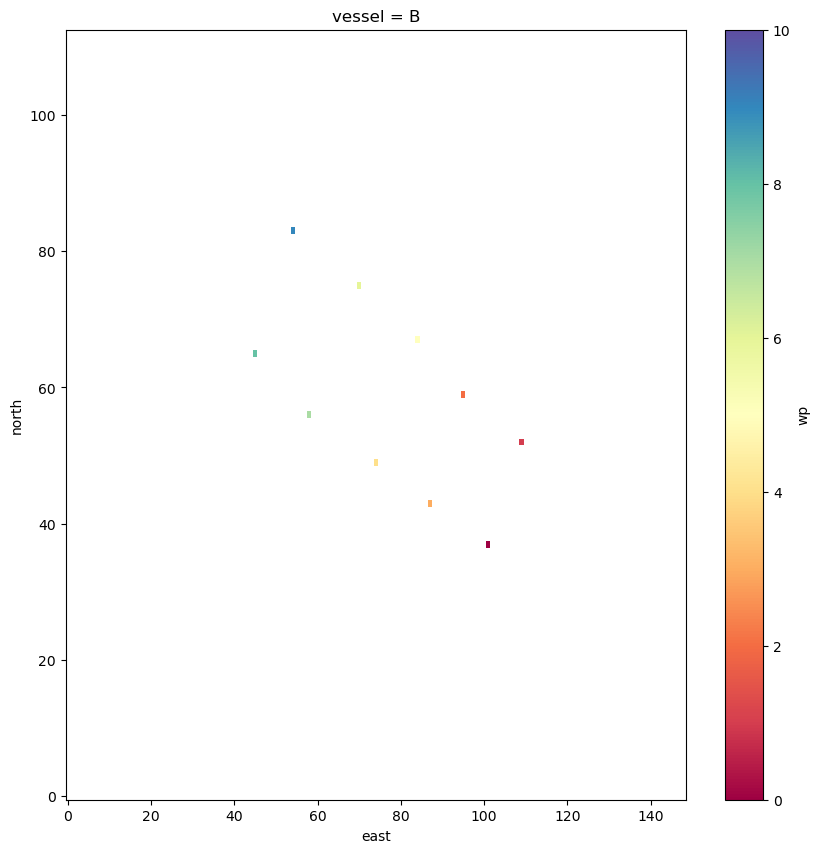

In [51]:
vT.wp.sel(vessel='B').plot(figsize=(10,10), vmin=0, vmax=10, cmap='Spectral')